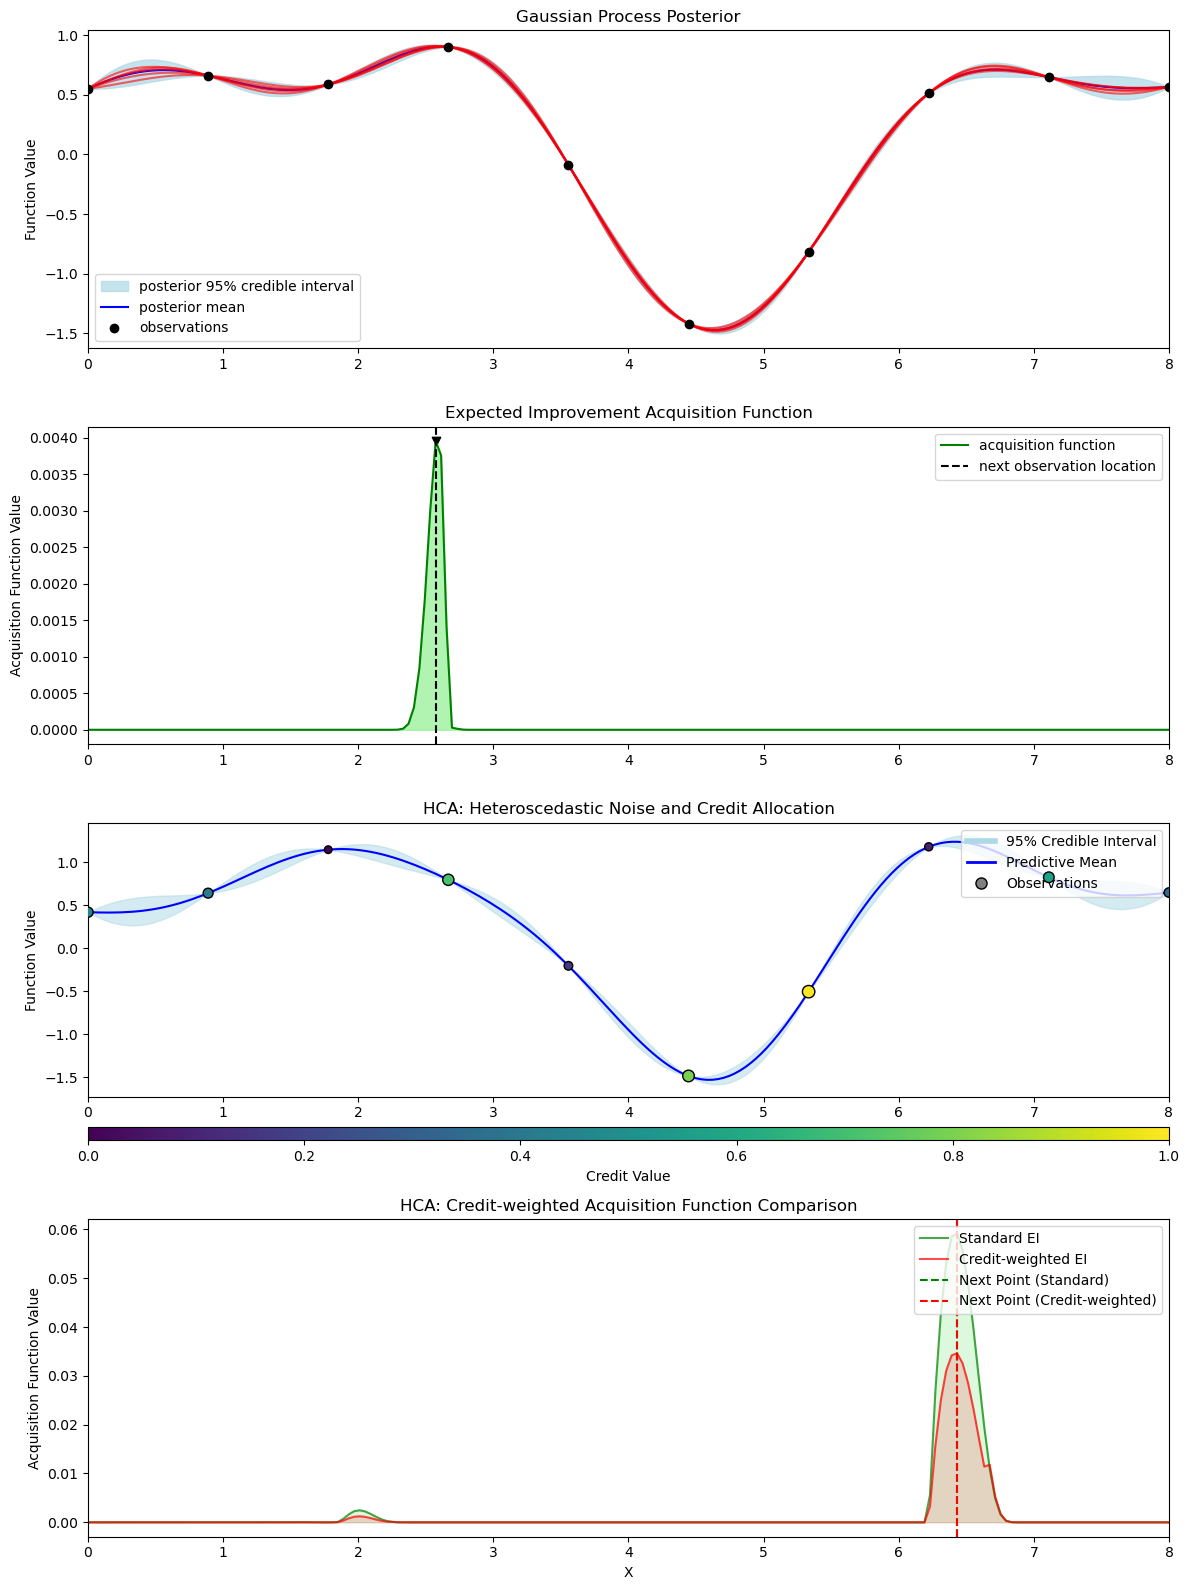

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from scipy.stats import norm
from scipy.spatial.distance import cdist
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Generate synthetic random data
np.random.seed(42)
X_obs = np.linspace(0, 8, 10).reshape(-1, 1)
Y_obs = np.sin(X_obs) + 0.5 * np.cos(2 * X_obs) + 0.1 * np.random.randn(10, 1)  

# Fit Gaussian Process
gp_model = GPy.models.GPRegression(X_obs, Y_obs, kernel=GPy.kern.RBF(input_dim=1, lengthscale=1.0))
gp_model.Gaussian_noise.variance = 0.01
gp_model.optimize()

# Predictions
X = np.linspace(0, 8, 200).reshape(-1, 1)
mu, variance = gp_model.predict(X)
sigma = np.sqrt(variance)

# Sampling from GP posterior (multiple samples)
samples = gp_model.posterior_samples_f(X, size=5)

# Acquisition Function (Expected Improvement example)
def EI(mu, sigma, f_best):
    with np.errstate(divide='warn'):
        Z = (mu - f_best) / sigma
        ei = (mu - f_best) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
        return ei

f_best = Y_obs.max()
ei = EI(mu.flatten(), sigma.flatten(), f_best)
next_x = X[np.argmax(ei)]

# Create a single figure with 4 subplots sharing the x-axis
fig = plt.figure(figsize=(12, 16))
ax1 = plt.subplot(4, 1, 1)
ax2 = plt.subplot(4, 1, 2, sharex=ax1)
ax3 = plt.subplot(4, 1, 3, sharex=ax1)
ax4 = plt.subplot(4, 1, 4, sharex=ax1)

# GP Posterior on ax1
ax1.fill_between(X.flatten(), (mu - 1.96 * sigma).flatten(), (mu + 1.96 * sigma).flatten(), 
                color='lightblue', alpha=0.7, label='posterior 95% credible interval')
ax1.plot(X, mu, 'b-', label='posterior mean')
for i in range(samples.shape[2]):
    ax1.plot(X, samples[:, :, i], 'r-', alpha=0.6)
ax1.plot(X_obs, Y_obs, 'ko', label='observations')
ax1.legend(loc='lower left')
ax1.set_ylabel('Function Value')
ax1.set_title('Gaussian Process Posterior')

# Acquisition function on ax2
ax2.plot(X, ei, 'g-', label='acquisition function')
ax2.fill_between(X.flatten(), 0, ei, color='lightgreen', alpha=0.7)
ax2.axvline(next_x, color='k', linestyle='--', label='next observation location')
ax2.scatter([next_x], [np.max(ei)], color='k', marker='v')
ax2.legend(loc='upper right')
ax2.set_ylabel('Acquisition Function Value')
ax2.set_title('Expected Improvement Acquisition Function')

# HCA Visualization - Part 1 on ax3
# Generate simulated credit values
np.random.seed(123)
credits = np.clip(np.abs(np.random.randn(len(X_obs))), 0.1, 2.0)

# Heteroscedastic noise based on credit values
noise_scale = 1.0 / np.sqrt(np.clip(credits, 0.1, 10.0))
noise_adjusted = np.array([ns * np.random.randn() for ns in noise_scale])

# Simulate synthetic heteroscedastic noise samples
X_hca = X_obs.copy()
Y_hca = Y_obs.copy() + noise_adjusted.reshape(-1, 1) * 0.2

# Fit GP model
kernel = GPy.kern.RBF(input_dim=1, lengthscale=1.0)
gp_hca = GPy.models.GPRegression(X_hca, Y_hca, kernel=kernel)
gp_hca.Gaussian_noise.variance = 0.01
gp_hca.optimize()

# Predictions
mu_hca, var_hca = gp_hca.predict(X)
sigma_hca = np.sqrt(var_hca)

# Visualize heteroscedastic noise and credit values
ax3.fill_between(X.flatten(), 
                (mu_hca - 1.96 * sigma_hca).flatten(), 
                (mu_hca + 1.96 * sigma_hca).flatten(), 
                color='lightblue', alpha=0.5, 
                label='95% Credible Interval')
ax3.plot(X, mu_hca, 'b-', label='Predictive Mean')

# Normalize credit values for visualization
normalized_credits = (credits - credits.min()) / (credits.max() - credits.min())

# Adjust point size based on credit values
sizes = 50 * normalized_credits + 30  # Ensure minimum visibility
scatter = ax3.scatter(X_hca, Y_hca, s=sizes, c=normalized_credits, 
                     edgecolor='k', cmap='viridis', 
                     label='Observations', zorder=10)

# Add a legend with smaller marker sizes to avoid overlap
legend_elements = [
    plt.Line2D([0], [0], color='lightblue', lw=4, label='95% Credible Interval'),
    plt.Line2D([0], [0], color='b', lw=2, label='Predictive Mean'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=8, label='Observations', markeredgecolor='k')
]
ax3.legend(handles=legend_elements, loc='upper right')
ax3.set_ylabel('Function Value')
ax3.set_title('HCA: Heteroscedastic Noise and Credit Allocation')

# Add colorbar at the bottom of the subplot
divider = make_axes_locatable(ax3)
cax = divider.append_axes("bottom", size="5%", pad=0.3)
cbar = plt.colorbar(scatter, cax=cax, orientation="horizontal")
cbar.set_label('Credit Value')

# HCA Visualization - Part 2 on ax4
# Calculate standard EI
f_best_hca = Y_hca.max()
ei_standard = EI(mu_hca.flatten(), sigma_hca.flatten(), f_best_hca)

# Calculate credit-weighted EI (simulation)
# Assign credit values to test points based on distance to known samples
dists = cdist(X, X_hca)
nearest_indices = np.argmin(dists, axis=1)
candidate_credits = credits[nearest_indices]
normalized_candidate_credits = (candidate_credits - candidate_credits.min()) / (candidate_credits.max() - candidate_credits.min())

# Credit-weighted EI
ei_credit = ei_standard * (normalized_candidate_credits + 0.5)  # Add offset to keep some weight on all points

# Get next sampling point locations
next_x_standard = X[np.argmax(ei_standard)]
next_x_credit = X[np.argmax(ei_credit)]

# Plot standard EI and credit-weighted EI
ax4.plot(X, ei_standard, 'g-', label='Standard EI', alpha=0.7)
ax4.plot(X, ei_credit, 'r-', label='Credit-weighted EI', alpha=0.7)
ax4.fill_between(X.flatten(), 0, ei_standard, color='lightgreen', alpha=0.3)
ax4.fill_between(X.flatten(), 0, ei_credit, color='lightcoral', alpha=0.3)

# Mark next sampling points
ax4.axvline(next_x_standard, color='g', linestyle='--', label='Next Point (Standard)')
ax4.axvline(next_x_credit, color='r', linestyle='--', label='Next Point (Credit-weighted)')
ax4.legend(loc='upper right')

ax4.set_xlabel('X')
ax4.set_ylabel('Acquisition Function Value')
ax4.set_title('HCA: Credit-weighted Acquisition Function Comparison')

# Set common x-limits for all subplots
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(0, 8)

plt.tight_layout()
plt.show()